In [18]:
# Importação de bibliotecas

import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, median_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Carregar dados
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/projCDat_25_1/datasets/cooked/_all/all_merged.csv')

# Visualizar as primeiras linhas
print(df.head())

# Verificar estatísticas básicas
print(df.describe())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   _ano _estado  _mes  car_c02_emitido  cli_pressao_atm_med  cli_temp_ar_med  \
0  2008      AC     7     2.627698e+07           986.843612        28.142731   
1  2008      AC     9     2.627698e+07           991.705941        24.446194   
2  2008      AC    10     2.627698e+07           990.328360        25.229298   
3  2008      AC    11     2.627698e+07           988.610987        25.195410   
4  2008      AC    12     2.627698e+07           988.692608        24.898790   

   cli_temp_orvalho_med  cli_umid_rel_med  cli_umid_rel_min_max  \
0             18.914978         59.555066                  95.0   
1             19.467987         75.811881                  97.0   
2             21.617473         81.870968                  96.0   
3             22.624478         86.905424                  96.0   
4             22.727554         88.529570              

In [17]:
# Remover linhas com valores nulos na variável alvo
df = df.dropna(subset=['que_area_queimada'])

# Separar variáveis e alvo
X = df.drop('que_area_queimada', axis=1)
y = df['que_area_queimada']

# Analisar a variavel alvo
print(y.describe())

# Definir colunas categóricas e numéricas
categorical_cols = ['_estado', '_mes']
numeric_cols = [col for col in X.columns if col not in categorical_cols and col != 'que_area_queimada']

# Transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

count    1.025000e+03
mean     1.091449e+05
std      2.512339e+05
min      1.000000e+00
25%      2.954000e+03
50%      1.435600e+04
75%      8.966600e+04
max      3.144010e+06
Name: que_area_queimada, dtype: float64


In [13]:
# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Pré-processamento
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Criar e treinar o modelo XGBoost
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=20,
    eval_metric='rmse'
)

model.fit(
    X_train_processed,
    y_train,
    eval_set=[(X_test_processed, y_test)],
    verbose=False
)

# Previsões
y_pred = model.predict(X_test_processed)


In [16]:
# Avaliação
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

# Exibir resultados
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape * 100:.2f}%')
print(f'MedAE: {medae:.2f}')
print(f'Explained Variance Score: {evs:.4f}')
print(f'RMSE: {rmse:.2f}')

RMSE: 162214.46
R²: 0.7016
MAE: 68368.18
MAPE: 2981.83%
MedAE: 13527.62
Explained Variance Score: 0.7018
RMSE: 162214.46


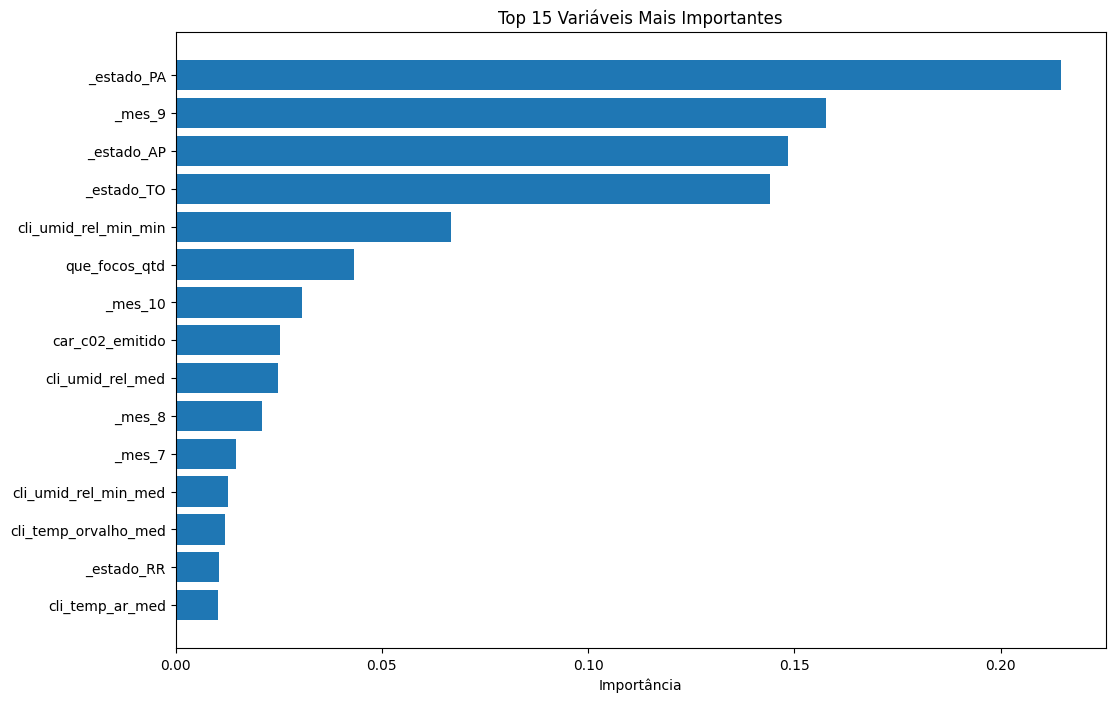

In [15]:
# Feature Importance
feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]

# Gráfico de importância
plt.figure(figsize=(12, 8))
plt.barh(np.array(feature_names)[sorted_idx][:15], importances[sorted_idx][:15])
plt.xlabel('Importância')
plt.title('Top 15 Variáveis Mais Importantes')
plt.gca().invert_yaxis()
plt.show()

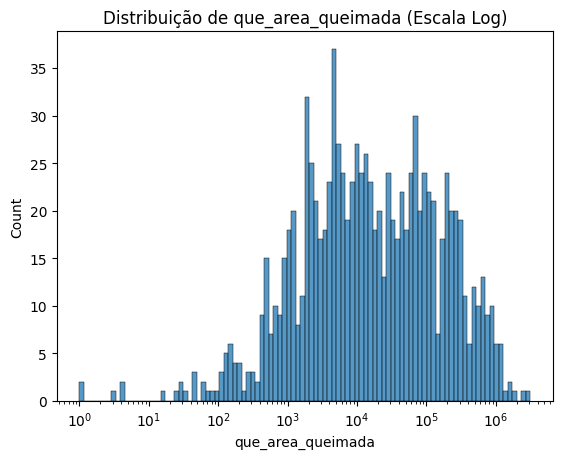

In [19]:
sns.histplot(y, bins=100, log_scale=True)
plt.title('Distribuição de que_area_queimada (Escala Log)')
plt.show()